Imports to featurize and load data

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features


Imports for Automl

In [2]:
import autosklearn.classification
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import sklearn.datasets
import sklearn.metrics

In [3]:
#make sure autosklearn is here
print('autosklearn: %s' % autosklearn.__version__)

autosklearn: 0.15.0


Data loaded as two dataframes of dances by features, one for basic and one for advanced movement sequences.
Comes from AIST. Downloaded all keypoints for Solo dances (Basic and Advanced = BM, FM)

In [4]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dfBasic, dfAdvanced = data_to_features(dataBM, dataFM)  #get features as dataframes


In [5]:
print('There are', len(dfBasic), 'Basic sequences and', len(dfAdvanced), 'Advanced sequences')

There are 1199 Basic sequences and 200 Advanced sequences


In [6]:
print(dfBasic.index.dtype)

int64


In [7]:
#alphabetize dfs by genre (to avoid reordering by classifiers later)
dfAdvanced = dfAdvanced.sort_values(by='Genre')

#make new indexes for Advanced, starting after last index in Basic, for unique index per id
#this is so that Basic and Adv indexes dont overlap.
dfAdvanced.index = range(len(dfBasic.index), len(dfBasic.index)+len(dfAdvanced.index))
dfAdvanced.head() 

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1199,1065.821287,100.792451,1735.653100,750.213614,8434.501762,3851.117291,2450.308351,669.453048,447.942426,10.535955,...,2.437719e+09,1.671086e+09,3.757403e+08,8.700107e+08,1.874843e+09,1.795367e+09,1.583052e+09,1.231693e+08,gJB_sFM_cAll_d07_mJB2_ch03,Ballet Jazz
1200,943.558702,94.981145,1440.802249,833.489400,7682.011394,5091.582272,-2047.497225,34163.471185,-241.612173,12.147221,...,1.778878e+09,1.684116e+09,2.406442e+08,8.035391e+09,1.480005e+10,9.934780e+09,6.696022e+09,3.330592e+09,gJB_sFM_cAll_d09_mJB5_ch20,Ballet Jazz
1201,952.453800,100.915748,1349.334022,759.992458,6434.637824,4151.000950,-33921.557899,1804.898380,-12073.446919,147.646347,...,2.006960e+09,1.939330e+09,4.561662e+08,8.840435e+08,3.678480e+09,3.672786e+09,2.399304e+09,6.016718e+08,gJB_sFM_cAll_d09_mJB1_ch16,Ballet Jazz
1202,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1203,980.392101,120.278649,1298.644834,864.940887,6144.367156,4303.434585,14075.825911,8935.725674,3590.248446,32.039323,...,1.568141e+09,1.418045e+09,9.868579e+07,4.798039e+08,1.410466e+09,1.192128e+09,1.032563e+09,1.548986e+08,gJB_sFM_cAll_d08_mJB0_ch08,Ballet Jazz


Test set is to be composed only of Advanced dances. This is because each Basic Movement has several, slightly modified versions of the same movement. Thus the problem is more general and more comparable to human genre judging if the test set is Advanced only. Below is a custom splitting function (see data_proc). I used it here for for getting a Test set that is composed entired of Advanced dances. 

Validation/calibration set complicates things, it can include either only Adv, or both.    
   
auto-sklearn improves from having a validation set with both (I tried 2 Adv and 14 Basic x 10 genres for calibration). XGBoost seems to do worse with a calibration split, so here it is zeroed it for simplicity and performance.  

   


In [8]:
from DanceProj1.data_proc import traintestval_split
train, valid, testset = traintestval_split(dfBasic, dfAdvanced, testfrac_adv=.502, testfrac_bas=0, valfrac_adv_nonT=0, valfrac_bas=0)
#trying with empty validation/calibration set, since XGB wasn't helped by calibration

In [9]:
print(len(testset), len(valid), len(train))

103 0 1296


In [10]:
testsetX = pd.DataFrame(columns=dfAdvanced.columns)
Genres = list(dfAdvanced.Genre.unique())        #get list of genres
for genre in Genres:                        #for each genre
    test_adv = dfAdvanced.loc[dfAdvanced.Genre == genre].sample(frac=.5, random_state=1) #get 50% of advanced dances
    testsetX = pd.concat([testsetX, test_adv])        #add to testset 
    
testsetX


,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1202,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1215,952.230629,103.339482,1173.811693,590.516327,5529.458983,2822.475105,-3101.460326,-3842.680385,-18763.210259,13.561335,...,7.749144e+08,6.417610e+08,3.189269e+08,1.187765e+08,9.508543e+08,7.796116e+08,6.957601e+08,1.061593e+08,gJB_sFM_cAll_d09_mJB2_ch17,Ballet Jazz
1205,932.590413,94.804736,1282.528269,711.093652,6148.346089,3447.588866,2243.048419,1894.560172,-653.568847,13.919868,...,1.022966e+09,9.799378e+08,3.563037e+07,8.464226e+07,7.898079e+08,7.237448e+08,6.997294e+08,3.808648e+07,gJB_sFM_cAll_d09_mJB3_ch18,Ballet Jazz
1209,993.748996,103.039502,1416.203426,661.718615,7210.700847,3842.351906,3191.516434,774.029072,10412.852893,8.008625,...,2.287331e+09,1.620000e+09,4.419914e+08,4.312722e+08,2.998522e+09,2.737176e+09,2.265183e+09,3.034734e+08,gJB_sFM_cAll_d07_mJB0_ch01,Ballet Jazz
1201,952.453800,100.915748,1349.334022,759.992458,6434.637824,4151.000950,-33921.557899,1804.898380,-12073.446919,147.646347,...,2.006960e+09,1.939330e+09,4.561662e+08,8.840435e+08,3.678480e+09,3.672786e+09,2.399304e+09,6.016718e+08,gJB_sFM_cAll_d09_mJB1_ch16,Ballet Jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,929.157439,76.353702,946.698851,476.445635,4656.507414,2610.520235,-7160.668144,21213.727168,-2148.497756,33.989235,...,6.633821e+08,6.341962e+08,4.136562e+07,2.113286e+08,3.970473e+08,3.117094e+08,2.537238e+08,5.886568e+07,gWA_sFM_cAll_d26_mWA4_ch12,Waack
1383,941.227338,79.309556,889.845354,332.760901,4440.282905,1499.912367,-2640.322744,4483.409450,-2890.444383,27.653056,...,3.665612e+08,3.107777e+08,3.406284e+07,3.639939e+08,7.809241e+08,6.589046e+08,6.146852e+08,7.030053e+07,gWA_sFM_cAll_d25_mWA1_ch02,Waack
1396,939.923978,68.239028,818.119115,372.186346,4164.762921,1884.353540,1088.842497,-11746.619719,10268.622584,5.731486,...,4.018333e+08,3.521439e+08,4.207317e+07,3.893858e+08,6.366089e+08,3.988821e+08,3.756609e+08,1.179205e+08,gWA_sFM_cAll_d27_mWA3_ch18,Waack
1386,971.873367,85.244858,1219.249706,475.971266,6437.832042,2477.818172,72.212928,2681.111962,1903.947720,10.636455,...,9.909399e+08,9.636795e+08,1.090725e+08,5.792683e+08,9.791640e+08,6.271363e+08,5.059277e+08,2.007120e+08,gWA_sFM_cAll_d25_mWA5_ch06,Waack


The dfs above include ID, for later evaluation. This column should be removed from input.  

traintestval_split also includes genre, which is our target label in this classification task and should accordingly be removed from x and used for y.

In [11]:
test_ids = testset['id']
index_lookup = pd.DataFrame(
               testset.index, columns=['original_index']) #lookup table for original index

X_test = testset.drop(['Genre'], axis=1).drop(['id'], axis=1)
y_test = testset['Genre']

X_valid = valid.drop(['Genre'], axis=1).drop(['id'], axis=1)
y_valid = valid['Genre']

X_train = train.drop(['Genre'], axis=1).drop(['id'], axis=1)
y_train = train['Genre']

In [12]:
X_test.index

Int64Index([1202, 1215, 1205, 1209, 1201, 1213, 1203, 1216, 1206, 1200,
            ...
            1382, 1395, 1385, 1389, 1381, 1393, 1383, 1396, 1386, 1380],
           dtype='int64', length=103)

In [13]:
#save test ids to csv
#test_ids.to_csv('test_ids.csv', index=False)

In [14]:
# check the shape 
for item in [X_train, X_test, X_valid, y_valid, y_train, y_test]:
  print(item.shape)

(1296, 104)
(103, 104)
(0, 104)
(0,)
(1296,)
(103,)


In [15]:
labels = list(y_test.unique())
print(labels)

['Ballet Jazz', 'Break', 'House', 'Krump', 'LAhop', 'Lock', 'Midhop', 'Pop', 'Street Jazz', 'Waack']


Let's see how a Perceptron does, no tuning

In [16]:
# from sklearn.linear_model import Perceptron
# preg = Perceptron(tol=.05, max_iter=2000, alpha=.00001).fit(X_train, y_train)
# print('Perceptron is at chance: Score =', preg.score(X_test, y_test))

Let's see how a Ridge Classifier does, no tuning 

In [17]:
# #Let's see how a ridge classifier does, no parameter tuning
# from sklearn.linear_model import RidgeClassifier
# rreg = RidgeClassifier().fit(X_train, y_train)
# print('RidgeClassifier is better than chance, but not great. Score =',rreg.score(X_test, y_test))

Let's see how XGBoost does

In [18]:
#convert to numeric labelsfor xgb
labels = list(y_test.unique())

y_trainxgb = y_train.replace(labels, list(range(len(labels))), regex=True)
y_validxgb = y_valid.replace(labels, list(range(len(labels))), regex=True)
y_testxgb = y_test.replace(labels, list(range(len(labels))), regex=True)
X_testxgb = X_test.replace(labels, list(range(len(labels))), regex=True)

print(list(zip(y_test.unique(), y_testxgb.unique())))

[('Ballet Jazz', 0), ('Break', 1), ('House', 2), ('Krump', 3), ('LAhop', 4), ('Lock', 5), ('Midhop', 6), ('Pop', 7), ('Street Jazz', 8), ('Waack', 9)]


In [33]:
import xgboost as xgb
#xgb_mod = xgb.XGBClassifier(objective='multi:softprob', eta =.2, max_depth =8, subsample =.6, random_state=42, n_jobs=16) #learning rate, max depth and subsample tuned empirically
xgb_mod = xgb.XGBClassifier(objective='multi:softprob', eta =.2, max_depth =8, subsample=.6, random_state=42, n_jobs=16) #learning rate, max depth and subsample tuned empirically
xgb_mod.fit(X_train, y_trainxgb)
print('XGBoost is not bad. Score =',xgb_mod.score(X_test, y_testxgb))

XGBoost is not bad. Score = 0.6407766990291263


In [30]:
y_hatprob = xgb_mod.predict_proba(X_test)   #get probabilities, turn into dataframe, add original index, true label, and id
yprobdf = pd.DataFrame(y_hatprob, columns=labels)   
yprobdf['Original Index'] = index_lookup['original_index']
yprobdf['True_Label'] = y_test.values
yprobdf['id'] = test_ids.values
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.083456,0.047125,0.017449,0.139542,0.034027,0.556116,0.008002,0.005815,0.093140,0.015329,1202,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.030213,0.019495,0.021670,0.099947,0.021792,0.727366,0.009668,0.016424,0.031419,0.022006,1215,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.034757,0.018497,0.005563,0.007844,0.008731,0.748651,0.004077,0.006879,0.037206,0.127793,1205,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
3,0.876464,0.007966,0.038532,0.014559,0.008963,0.025079,0.011941,0.001287,0.008566,0.006643,1209,Ballet Jazz,gJB_sFM_cAll_d07_mJB0_ch01
4,0.974399,0.002129,0.000921,0.000804,0.000478,0.013272,0.000605,0.001026,0.004221,0.002146,1201,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16


In [31]:
#split into dfs by genre
BJazzdf = yprobdf[yprobdf['True_Label']=='Ballet Jazz']
Breakdf = yprobdf[yprobdf['True_Label']=='Break']
Housedf = yprobdf[yprobdf['True_Label']=='House']
Krumpdf = yprobdf[yprobdf['True_Label']=='Krump']
LAhopdf = yprobdf[yprobdf['True_Label']=='LAhop']
Lockdf = yprobdf[yprobdf['True_Label']=='Lock']
Midhopdf = yprobdf[yprobdf['True_Label']=='Midhop']
Popdf = yprobdf[yprobdf['True_Label']=='Pop']
SJazzdf = yprobdf[yprobdf['True_Label']=='Street Jazz']
Waackdf = yprobdf[yprobdf['True_Label']=='Waack']

Genredfs = [BJazzdf, Breakdf, Housedf, Krumpdf, LAhopdf, Lockdf, Midhopdf, Popdf, SJazzdf, Waackdf]


([<matplotlib.axis.YTick at 0x7f5261819dc0>,
 [Text(0, 0, 'Ballet Jazz'),
  Text(0, 1, 'Break'),
  Text(0, 2, 'House'),
  Text(0, 3, 'Krump'),
  Text(0, 4, 'LAhop'),
  Text(0, 5, 'Lock'),
  Text(0, 6, 'Midhop'),
  Text(0, 7, 'Pop'),
  Text(0, 8, 'Street Jazz'),
  Text(0, 9, 'Waack')])

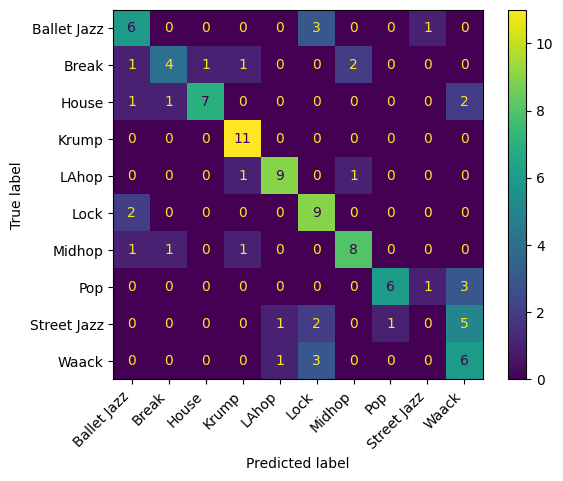

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_mod, X_testxgb, y_testxgb)
#change xticks and yticks to labels
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels, rotation=45, ha='right')
plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels)


In [50]:
!ls ../

DanceObj.py	 XGB_Genreclass.py  __pycache__  data_proc.py  plots	 videos
DanceObj_old.py  __init__.py	    config.py	 notebooks     setup.py


<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: title={'center': 'Ballet Jazz'}, ylabel='Probability'>

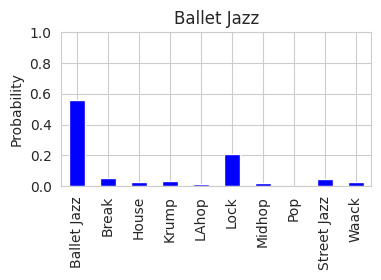

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
plt.show()
dfBJ = BJazzdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfBJ.mean().plot(kind='bar', title='Ballet Jazz', color='blue', figsize=(4,2), ylim=(0,1), ylabel='Probability')



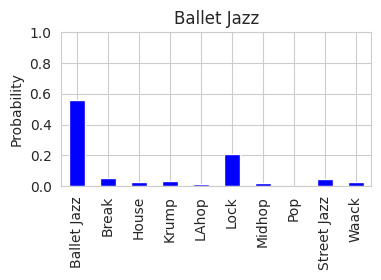

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
#remove original index, true label, and id for each house pieces, plt the mean probabiltiies
sns.set_style('whitegrid')
dfBJ = BJazzdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfBJ.mean().plot(kind='bar', title='Ballet Jazz', color='blue', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/BJazzprob.png')


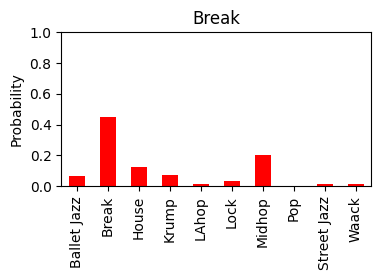

In [52]:
dfBR = Breakdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfBR.mean().plot(kind='bar', title='Break', color='red', figsize=(4,2), ylim=(0,1), ylabel='Probability')
#plot aethestic
plt.
plt.savefig('../plots/proba_plots/Breakprob.png')


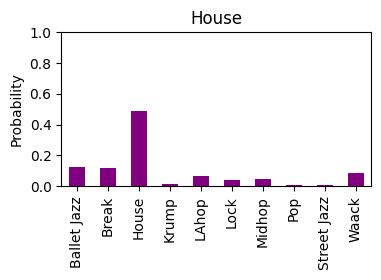

In [53]:
dfHO = Housedf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfHO.mean().plot(kind='bar', title='House', color='purple', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Houseprob.png')

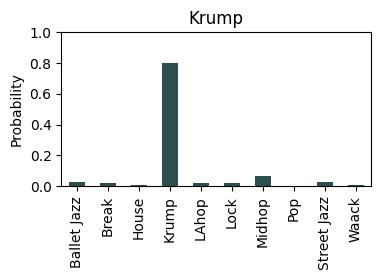

In [54]:
dfKR = Krumpdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfKR.mean().plot(kind='bar', title='Krump', color='darkslategray', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Krumpprob.png')

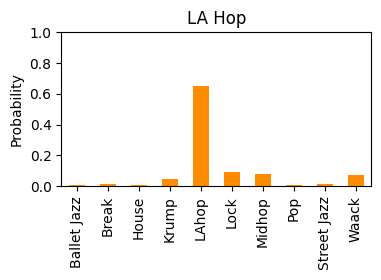

In [55]:
dfLA = LAhopdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfLA.mean().plot(kind='bar', title='LA Hop', color='darkorange', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/LAprob.png')

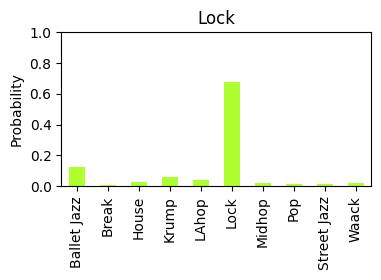

In [56]:
dfLO = Lockdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfLO.mean().plot(kind='bar', title='Lock', color='greenyellow', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Lockprob.png')

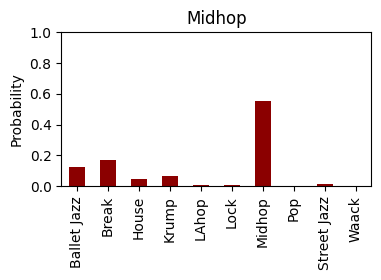

In [57]:
dfMI = Midhopdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfMI.mean().plot(kind='bar', title='Midhop', color='darkred', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Midprob.png')

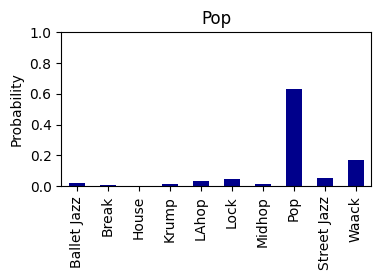

In [58]:
dfPO = Popdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfPO.mean().plot(kind='bar', title='Pop', color='darkblue', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Popprob.png')

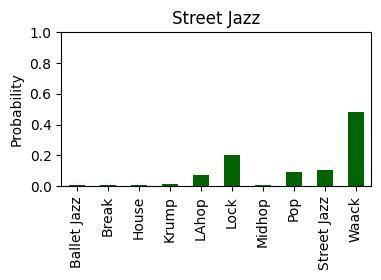

In [59]:
dfSJ = SJazzdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfSJ.mean().plot(kind='bar', title='Street Jazz', color='darkgreen', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/SJprob.png')

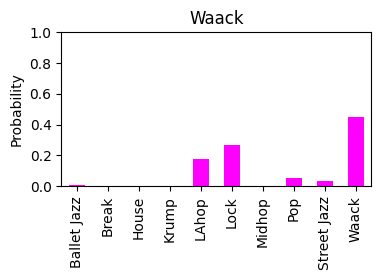

In [60]:
dfWA = Waackdf.drop(['Original Index', 'True_Label', 'id'], axis=1)
dfWA.mean().plot(kind='bar', title='Waack', color='magenta', figsize=(4,2), ylim=(0,1), ylabel='Probability')
plt.savefig('../plots/proba_plots/Waackprob.png')

In [36]:
# from sklearn.preprocessing import StandardScaler
# #scale X_test and X_train
# scaled_XTest = StandardScaler().fit_transform(X_test)
# scaled_Xtrain = StandardScaler().fit_transform(X_train)

# X_test = pd.DataFrame(scaled_XTest, index=X_test.index, columns=X_test.columns)
# X_train = pd.DataFrame(scaled_Xtrain, index=X_train.index, columns=X_train.columns)
# X_test.head()

#scaling actually hurt performance for Ridge and XGB

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_height_jer,Contracorr_Relb_Lknee_prominencej1,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std
1202,-0.287615,0.255923,0.047981,0.593541,0.012614,0.756294,0.049036,-1.181280,0.535683,-0.220856,...,-0.431206,0.726546,0.706377,0.106083,1.357485,0.100669,0.051288,0.145323,0.292515,-0.229346
1215,-0.867918,0.205833,-0.158938,0.171978,-0.354685,0.105734,-0.033185,-0.521927,-1.252712,-0.190777,...,1.080689,0.287417,-0.350819,-0.449541,1.379088,-0.422480,-0.250737,-0.268950,-0.271445,-0.210412
1205,-1.199865,0.064041,0.134228,0.576403,-0.041979,0.506132,0.074480,0.312392,-0.027223,-0.189353,...,-0.454502,-0.141842,0.082741,0.224087,-0.681507,-0.459423,-0.346733,-0.314704,-0.267192,-0.402859
1209,-0.166201,0.200849,0.494698,0.410796,0.494799,0.758985,0.093586,0.149443,0.721648,-0.212831,...,3.132164,2.124262,2.292671,1.499052,2.274213,-0.084271,0.969835,1.334260,1.410017,0.347407
1201,-0.864146,0.165566,0.314377,0.740414,0.102676,0.956681,-0.654050,0.299353,-0.800012,0.341759,...,3.341772,2.468854,1.802622,2.135139,2.377316,0.405756,1.375144,2.100508,1.553713,1.190433


In [52]:
from sklearn.calibration import CalibratedClassifierCV
calibrxgb = CalibratedClassifierCV(xgb_mod, cv='prefit', method='sigmoid')

calibrxgb.fit(X_valid, y_validxgb)
y_hatpc = calibrxgb.predict_proba(X_test)
print(y_hatpc.shape)
print('Calibrated XGBoost is...worse? Score =',calibrxgb.score(X_test, y_testxgb))

(103, 10)
Calibrated XGBoost is...worse? Score = 0.49514563106796117


##### Now for auto-sklearn. The two main parameters for auto-sklearn are:   
- time_left_for_this_task, optional (default=3600): Time limit in seconds for the search of appropriate models. By increasing this value, auto-sklearn has a higher chance of finding better models.  
- per_run_time_limit, optional (default=1/10 of time_left_for_this_task): Time limit for a single call to the machine learning model. Model fitting will be terminated if the machine learning algorithm runs over the time limit. Set this value high enough so that typical machine learning algorithms can be fit on the training data.


In [ ]:
#todo, edit below based on jupyter notebook from lab box

In [ ]:
# Instantiate an automl classifier model object with time limits
automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=400,
        per_run_time_limit=50
)

# Fit the classifier to training data
automl.fit(X_train, y_train)
print('Score =', automl.score(X_test, y_test))

In [ ]:
# Model search statistics
print(automl.sprint_statistics())

In [ ]:
# Model Description
print(automl.show_models())

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibr = CalibratedClassifierCV(automl, cv='prefit', method='isotonic')

calibr.fit(X_valid, y_valid)
y_hatp = calibr.predict_proba(X_test)